<a href="https://colab.research.google.com/github/salmazahrara/2025_VISI_KOMPUTER_TI2A/blob/main/Praktikum_Regresi_Salma%20Zahra%20Ramadhani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum D1 - Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

In [ ]:
# Setup & Generator Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y

    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi

    img = (img / 255.0).astype(np.float32)

    # 3-channel biar kompatibel dengan CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)

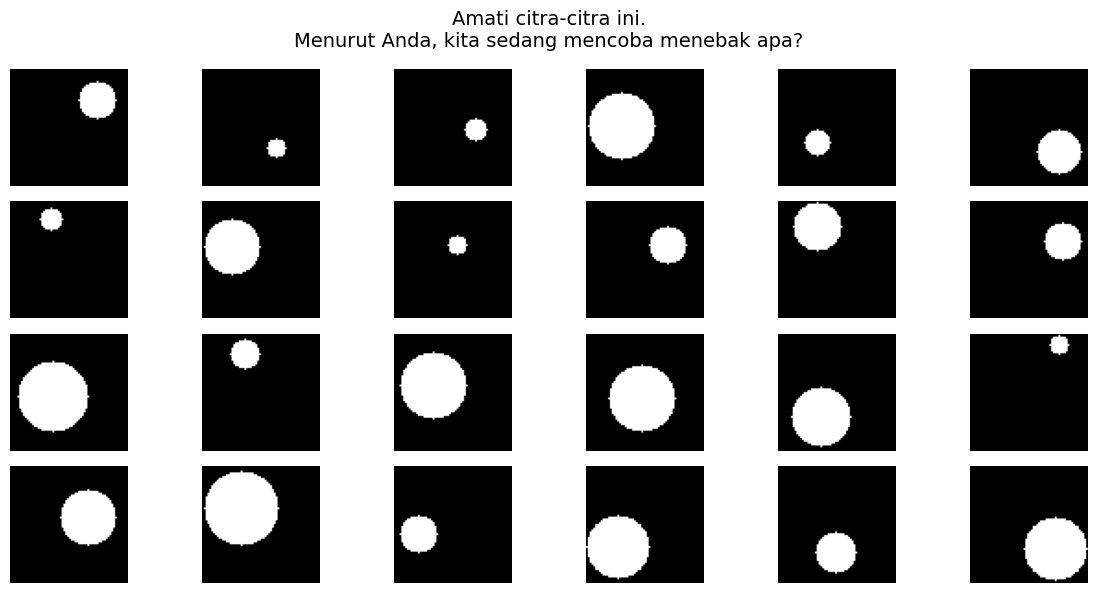

In [ ]:
# “Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle(
    "Amati citra-citra ini.\nMenurut Anda, kita sedang mencoba menebak apa?",
    fontsize=14
)
plt.tight_layout()
plt.show()


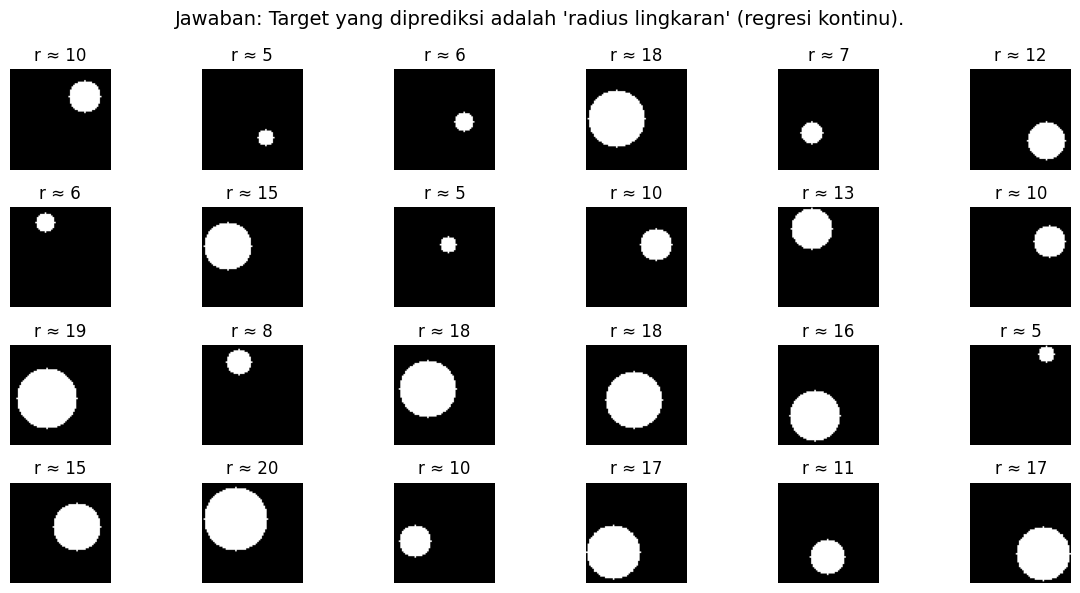

In [ ]:
# Buka Jawaban — Target yang Ingin Diprediksi
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle(
    "Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).",
    fontsize=14
)
plt.tight_layout()
plt.show()


In [ ]:
# (Opsional) Latih CNN Kecil untuk Memprediksi Radius
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
# Model CNN sederhana
model = models.Sequential([
layers.Input((64,64,3)),
layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
layers.Conv2D(128, 3, activation='relu'),
layers.GlobalAveragePooling2D(),
layers.Dense(64, activation='relu'),
layers.Dense(1) # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
epochs=12, batch_size=64, verbose=0)
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.971 | RMSE=1.171 | R2=0.935


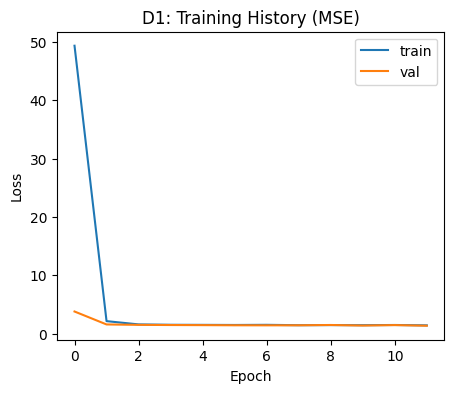

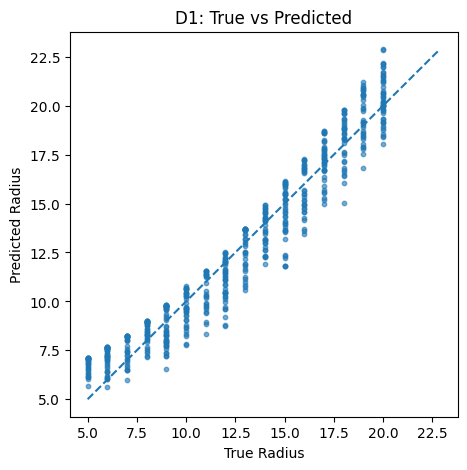

In [ ]:
# Plot history & True vs Predicted:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()
# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

In [ ]:
# Tantangan Mini (Opsional untuk Mahasiswa)
# - Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R2.
# - Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
# - Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus;
# metrik evaluasi apa yang cocok?

In [ ]:
# mini challange

# =====================================================
# EXPERIMEN CNN REGRESI RADIUS & POSISI LINGKARAN
# =====================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import cv2

# -----------------------------------------------------
# 1️⃣ Fungsi untuk membuat citra lingkaran
# -----------------------------------------------------
def make_sample(img_size=64, r_range=(8, 28), add_noise=False):
    img = np.zeros((img_size, img_size, 3), dtype=np.float32)
    r = np.random.uniform(*r_range)
    cx, cy = np.random.uniform(r, img_size - r, 2)

    # gambar lingkaran putih di background hitam
    yy, xx = np.mgrid[:img_size, :img_size]
    mask = (xx - cx)**2 + (yy - cy)**2 <= r**2
    img[mask] = 1.0

    # tambahkan noise opsional
    if add_noise:
        img = cv2.GaussianBlur(img, (5,5), 1)
        img += np.random.normal(0, 0.05, img.shape)
        img = np.clip(img, 0, 1)

    return img, r, (cx, cy)

# -----------------------------------------------------
# 2️⃣ Siapkan dataset
# -----------------------------------------------------
N = 3000
X, y, C = zip(*[make_sample(add_noise=True) for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array([[r, cx, cy] for r, (cx, cy) in zip(y, C)], dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi opsional (sudah 0–1 dari awal)
print("Dataset:", Xtr.shape, ytr.shape)

# -----------------------------------------------------
# 3️⃣ Model CNN Multi-Output [r, cx, cy]
# -----------------------------------------------------
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)  # output r, cx, cy
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# -----------------------------------------------------
# 4️⃣ Training
# -----------------------------------------------------
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=1,
    callbacks=cb
)

# -----------------------------------------------------
# 5️⃣ Evaluasi
# -----------------------------------------------------
y_pred = model.predict(Xte)

mae_r = mean_absolute_error(yte[:,0], y_pred[:,0])
mae_cx = mean_absolute_error(yte[:,1], y_pred[:,1])
mae_cy = mean_absolute_error(yte[:,2], y_pred[:,2])

rmse_r = np.sqrt(np.mean((yte[:,0]-y_pred[:,0])**2))
rmse_cx = np.sqrt(np.mean((yte[:,1]-y_pred[:,1])**2))
rmse_cy = np.sqrt(np.mean((yte[:,2]-y_pred[:,2])**2))

r2_r = r2_score(yte[:,0], y_pred[:,0])
r2_cx = r2_score(yte[:,1], y_pred[:,1])
r2_cy = r2_score(yte[:,2], y_pred[:,2])

print(f"\n📊 HASIL EVALUASI:")
print(f"MAE_r={mae_r:.3f}, MAE_cx={mae_cx:.3f}, MAE_cy={mae_cy:.3f}")
print(f"RMSE_r={rmse_r:.3f}, RMSE_cx={rmse_cx:.3f}, RMSE_cy={rmse_cy:.3f}")
print(f"R²_r={r2_r:.3f}, R²_cx={r2_cx:.3f}, R²_cy={r2_cy:.3f}")

# -----------------------------------------------------
# 6️⃣ Plot Loss
# -----------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.show()

# -----------------------------------------------------
# 7️⃣ Scatter Plot: True vs Predicted per output
# -----------------------------------------------------
fig, axes = plt.subplots(1,3, figsize=(15,5))
titles = ['Radius', 'Center X', 'Center Y']
for i, ax in enumerate(axes):
    ax.scatter(yte[:,i], y_pred[:,i], s=10, alpha=0.6)
    lims = [min(yte[:,i].min(), y_pred[:,i].min()),
            max(yte[:,i].max(), y_pred[:,i].max())]
    ax.plot(lims, lims, '--', color='red')
    ax.set_title(titles[i])
    ax.set_xlabel('True'); ax.set_ylabel('Predicted')
plt.show()

# -----------------------------------------------------
# 8️⃣ Visualisasi Contoh Hasil Prediksi
# -----------------------------------------------------
n_show = 5
plt.figure(figsize=(12,3))
for i in range(n_show):
    idx = np.random.randint(0, len(Xte))
    img = Xte[idx]
    r_true, cx_true, cy_true = yte[idx]
    r_pred, cx_pred, cy_pred = y_pred[idx]

    plt.subplot(1, n_show, i+1)
    plt.imshow(img)
    # lingkaran asli (hijau)
    circ1 = plt.Circle((cx_true, cy_true), r_true, color='lime', fill=False, linewidth=2)
    # prediksi (merah)
    circ2 = plt.Circle((cx_pred, cy_pred), r_pred, color='red', fill=False, linewidth=2)
    plt.gca().add_patch(circ1)
    plt.gca().add_patch(circ2)
    plt.axis('off')
plt.suptitle("Hijau = True | Merah = Predicted")
plt.show()


## Langkah 2 -  Mengunggah keggle.json ke Colab

In [ ]:
# jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer anda

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"salmazahraramadhani","key":"7b37e88673270ac63155bc25a775d112"}'}

- menyiapkan koneksi untuk kaggle

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod (os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else :
  print("⚠️ kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


## Langkah 3 - Mengunduh Dataset UTKFace dari Kaggle

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil di ekstrak")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil di ekstrak


##  Langkah 4 - Menampilkan Contoh Gaambar Dataset

Total gambar ditemukan : 23708


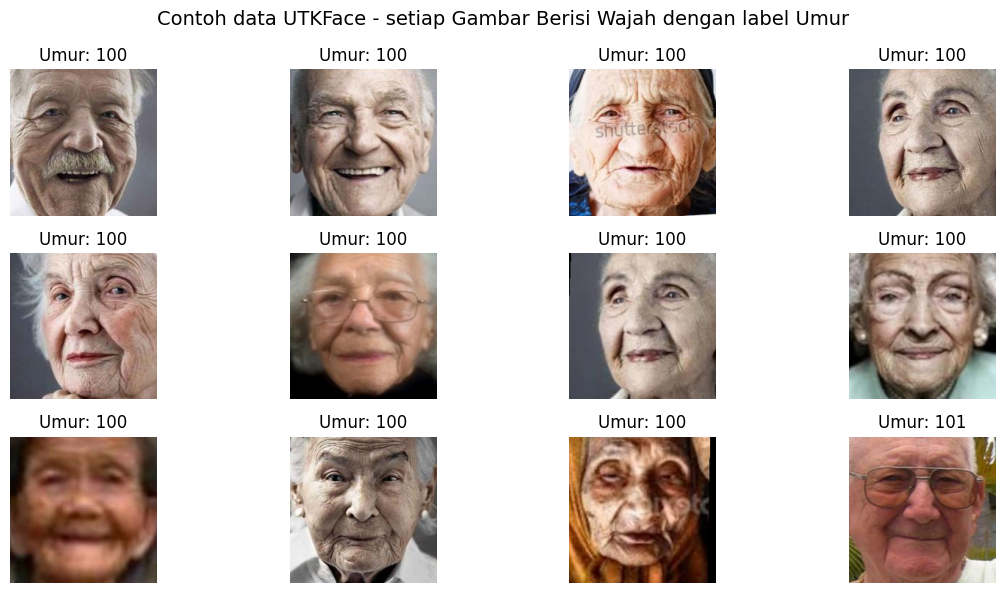

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan : {len(files)}")

plt.figure(figsize = (12, 6))
for i, f in enumerate(files[:12]):
  # ambil umur dari nama file
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")
plt.suptitle("Contoh data UTKFace - setiap Gambar Berisi Wajah dengan label Umur", fontsize=14)
plt.tight_layout()
plt.show()


## Langkah 5 Siapkan dataset untuk model


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, tesr_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files,
y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((tesr_files,
y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


## Langkah 6 — Membangun Model dengan Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPI jika tersedia
print ("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else ("CPU"))

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = False # Tahap awal : freeze backbone

# Tambahkan hear regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x =tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal : umur
model = tf.keras.Model(inputs, outputs)

# kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse', metrics=['mae'])
model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Langkah 7 - Melatih model (Tahap 1 - Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 53s 126ms/step - loss: 340.5656 - mae: 13.5597 - val_loss: 159.7487 - val_mae: 9.6411 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 153.8376 - mae: 9.2849 - val_loss: 146.5240 - val_mae: 9.1051 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 146.0522 - mae: 8.9446 - val_loss: 139.9780 - val_mae: 8.7787 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 140.9400 - mae: 8.7411 - val_loss: 140.6244 - val_mae: 8.8655 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 136.7495 - mae: 8.6032 - val_loss: 134.9200 - val_mae: 8.5366 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 136.5130 - mae: 8.5550 - val_loss: 137.1228 - val_mae: 8.7288 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 132.3964 - mae: 8.4283 - val_loss: 134.2233 - va

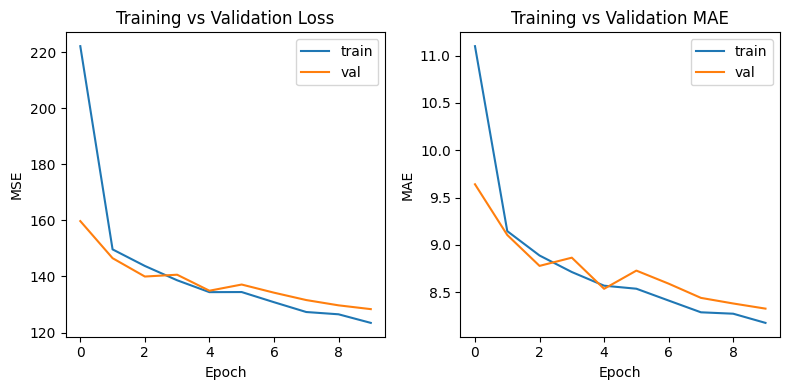

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3, restore_best_weights=True, monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 55s 98ms/step - loss: 185.2201 - mae: 10.0639 - val_loss: 134.8538 - val_mae: 8.7146 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 78.1508 - mae: 6.5878 - val_loss: 127.5726 - val_mae: 8.7647 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 52.0101 - mae: 5.4517 - val_loss: 124.1860 - val_mae: 8.5614 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 37.8461 - mae: 4.6557 - val_loss: 106.1347 - val_mae: 7.7061 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 31.2336 - mae: 4.2479 - val_loss: 102.2731 - val_mae: 7.4593 - learning_rate: 1.0000e-04


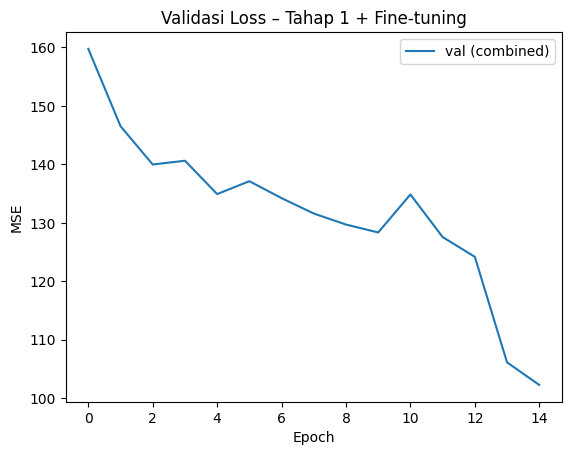

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
         label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE = 7.46 tahun
RMSE = 10.11 tahun
R2 = 0.742


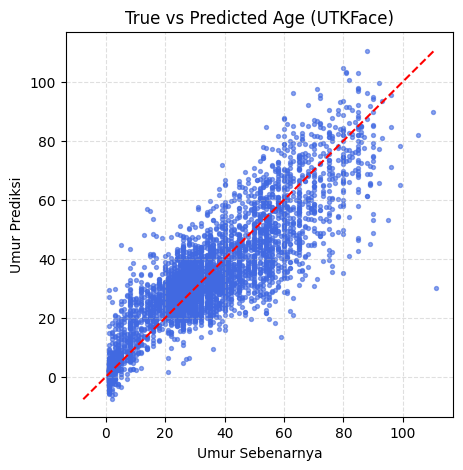

In [ ]:
from math import sqrt
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")
# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


In [ ]:
#  ekstrak gambar
import zipfile
import os
import glob

# 1️⃣ Ekstrak file zip
with zipfile.ZipFile("/content/utkface-new.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/utkface-new")

# 2️⃣ Cek lokasi hasil ekstrak
print("Isi folder utkface-new:")
!ls /content/utkface-new | head

# 3️⃣ Ambil semua file gambar
test_dir = "/content/utkface-new"
test_files = glob.glob(os.path.join(test_dir, "*.jpg"))
print("Jumlah file test:", len(test_files))


Isi folder utkface-new:
crop_part1
UTKFace
utkface_aligned_cropped
Jumlah file test: 0


In [ ]:
import glob, os

# cek folder mana yang berisi file .jpg
for folder in ["crop_part1", "UTKFace", "utkface_aligned_cropped"]:
    path = f"/content/utkface-new/{folder}"
    files = glob.glob(os.path.join(path, "*.jpg"))
    print(f"{folder}: {len(files)} file ditemukan")


crop_part1: 9780 file ditemukan
UTKFace: 23708 file ditemukan
utkface_aligned_cropped: 0 file ditemukan


Jumlah file test: 23708


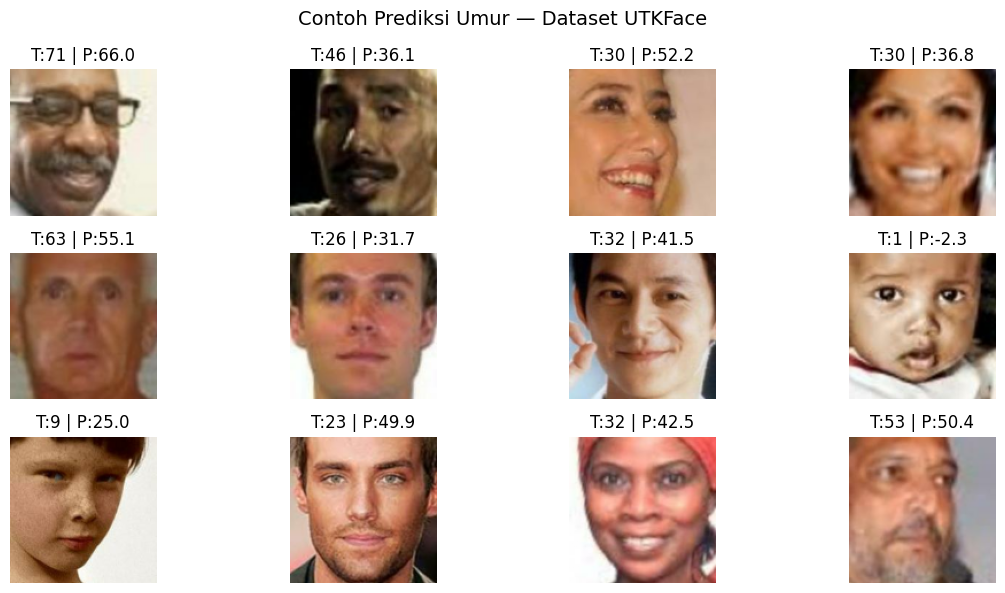

In [ ]:
import glob, os, random
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 128  # sesuaikan dengan ukuran yang kamu pakai

# ambil file dari folder yang berisi gambar
test_files = glob.glob("/content/utkface-new/UTKFace/*.jpg")

print("Jumlah file test:", len(test_files))

# pastikan minimal 12 file
if len(test_files) >= 12:
    sample_paths = random.sample(test_files, 12)
else:
    sample_paths = test_files  # kalau kurang dari 12, ambil semua

plt.figure(figsize=(12,6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import random
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths): img = tf.io.read_file(path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 true_age = int(os.path.basename(path).split('_')[0])
pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0] plt.subplot(3,4,i+1)
plt.imshow(img.numpy()) plt.title(f"T:{true_age} | P:{pred_age:.1f}") plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14) plt.tight_layout()
plt.show()


Saving WIN_20250416_14_42_16_Pro.jpg to WIN_20250416_14_42_16_Pro.jpg


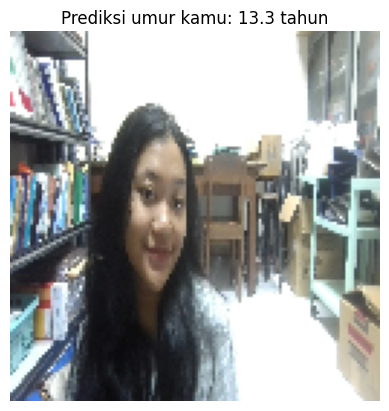

In [ ]:
# COBA

# Upload foto wajah kamu (format .jpg)
from google.colab import files
uploaded = files.upload()

img_path = list(uploaded.keys())[0]

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
plt.imshow(img.numpy())
plt.title(f"Prediksi umur kamu: {pred_age:.1f} tahun")
plt.axis('off')
plt.show()


### Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

In [5]:
# 1️⃣ Upload kaggle.json dari komputer kamu
from google.colab import files
files.upload()  # Pilih file kaggle.json

import os, shutil

# 2️⃣ Pindahkan ke folder .kaggle
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("❌ kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


In [6]:
# 2
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")
y

replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/paw/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/paw/test/4128bae22183829d2b5fea10effdb0c3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/paw/test/43a2262d7738e3d420d453815151079e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/paw/test/4e429cead1848a298432a0acad014c9d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

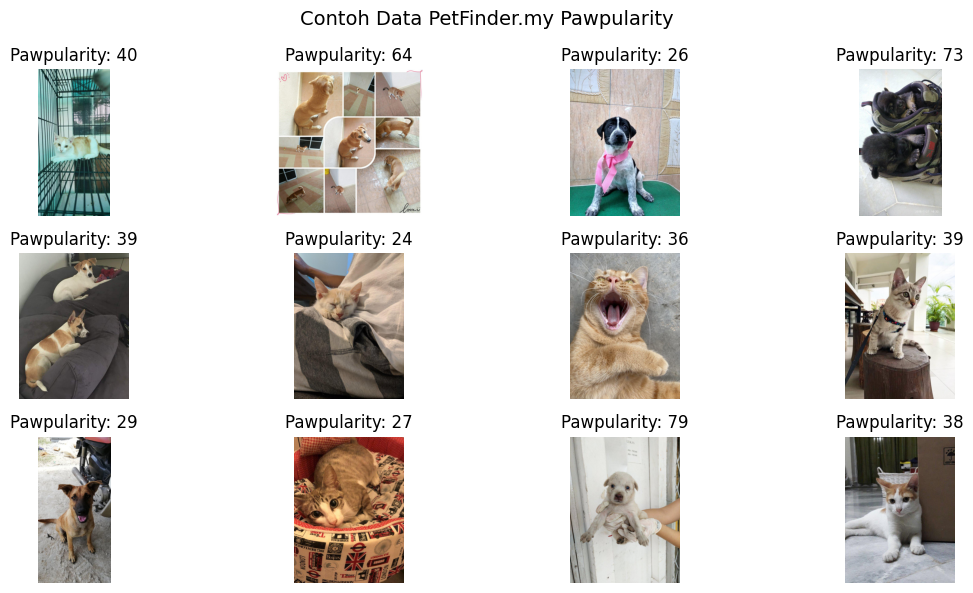

In [8]:
# 3️⃣ Visualisasi Data Pawpularity
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [9]:
# 4️⃣ Persiapan Data untuk Training & Validasi
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

# Pisahkan data train dan validasi
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Fungsi untuk memuat dan preprocessing gambar
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0  # normalisasi
    return img, tf.cast(label, tf.float32)

# Dataset training
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4096)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset validasi
val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"✅ Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


✅ Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


In [10]:
# 5️⃣ Membangun Model CNN (Transfer Learning - EfficientNetB0)
from tensorflow.keras import layers, models
import tensorflow as tf

# Gunakan EfficientNetB0 pretrained dari ImageNet
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # Freeze layer base sementara

# Input layer
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

# ✅ Preprocessing bawaan EfficientNet (yang benar)
from tensorflow.keras.applications.efficientnet import preprocess_input
x = preprocess_input(inputs * 255.0)

# Feature extraction
x = base(x, training=False)

# Fully connected layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)

# Output layer — regresi (prediksi nilai Pawpularity)
outputs = layers.Dense(1)(x)

# Bangun model
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Tampilkan arsitektur model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# 5
from sklearn.model_selection import train_test_split
import tensorflow as tf

cb = [
tf.keras.callbacks.EarlyStopping(patience=3,
restore_best_weights=True),
tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=1,
callbacks=cb, verbose=1)

124/124 ━━━━━━━━━━━━━━━━━━━━ 778s 6s/step - loss: 819.1240 - mae: 21.7068 - val_loss: 479.7733 - val_mae: 16.0092 - learning_rate: 0.0010


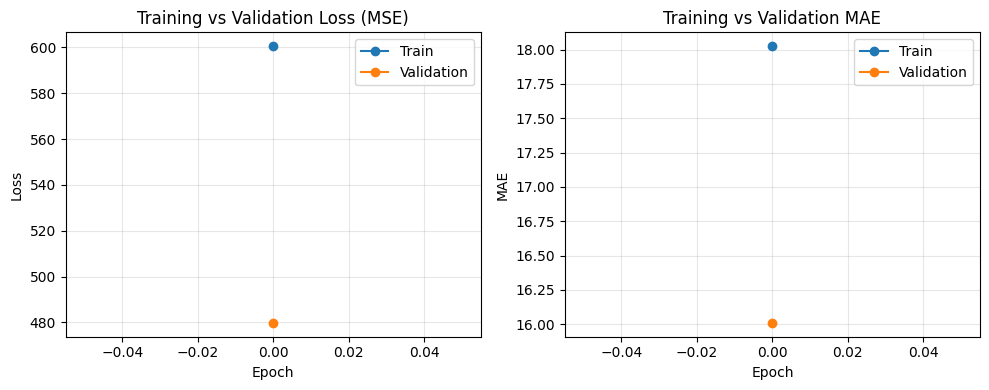

In [15]:
import matplotlib.pyplot as plt

# =====================================================
# Plot Training & Validation Loss / MAE
# =====================================================
plt.figure(figsize=(10,4))

# -------------------------
# 1️⃣ Loss
# -------------------------
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train', marker='o')
plt.plot(history.history['val_loss'], label='Validation', marker='o')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# -------------------------
# 2️⃣ MAE
# -------------------------
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train', marker='o')
plt.plot(history.history['val_mae'], label='Validation', marker='o')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# =====================================================
# 1️⃣ Siapkan nilai True & Prediksi
# =====================================================
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel()
    for batch in val_ds
])

# =====================================================
# 2️⃣ Hitung metrik evaluasi
# =====================================================
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# =====================================================
# 3️⃣ Plot True vs Predicted
# =====================================================
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=15, alpha=0.5, color='blue')
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red', linewidth=1.5)

plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
!wget -O UTKFace.tar.gz https://susanqq.github.io/UTKFace.tar.gz


--2025-10-15 17:58:38--  https://susanqq.github.io/UTKFace.tar.gz
Resolving susanqq.github.io (susanqq.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to susanqq.github.io (susanqq.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-15 17:58:38 ERROR 404: Not Found.



In [ ]:
!tar -xvzf UTKFace.tar.gz


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Misal dataset disimpan di folder ini:
DATASET_DIR = ""DATASET_DIR = "UTKFace"
# Pisahkan jadi train/test (contoh: 80% train, 20% test)
split = int(0.8 * len(all_files))
test_files = all_files[split:]

# Lanjutkan dengan kode kamu
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (ipython-input-2034965322.py, line 7)

In [ ]:
# 8
import random
from PIL import Image
sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
img = Image.open(row.path)
pred = model.predict(tf.expand_dims(load_image(row.path,
row.Pawpularity)[0], 0), verbose=0).ravel()[0]
plt.subplot(3,4,i+1)
plt.imshow(img)
plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


IndentationError: expected an indented block after 'for' statement on line 6 (ipython-input-3490336250.py, line 7)

Saving ilustrasi-kucing-oranye_43.jpeg to ilustrasi-kucing-oranye_43.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


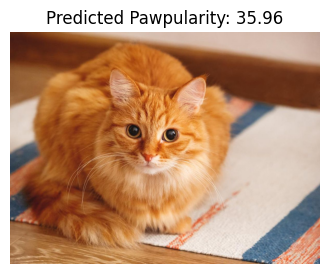

Prediksi Skor Pawpularity untuk foto 'ilustrasi-kucing-oranye_43.jpeg' adalah: 35.96
Semakin tinggi nilai, semakin menarik foto menurut model.


In [19]:
# PAWWWWWWWWWw

# =====================================================
# 🐾 Uji Model Pawpularity dengan Foto Sendiri
# =====================================================

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import files

# 1️⃣ Upload foto sendiri (atau hewan peliharaan)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2️⃣ Load dan preprocessing gambar
img = Image.open(filename).convert('RGB')
img_resized = img.resize((224, 224))  # ukuran sesuai input EfficientNetB0
img_array = np.array(img_resized) / 255.0  # normalisasi
img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimensi

# 3️⃣ Prediksi skor Pawpularity
pred_score = model.predict(img_array)[0][0]

# 4️⃣ Tampilkan hasil
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Pawpularity: {pred_score:.2f}")
plt.show()

print("=====================================================")
print(f"Prediksi Skor Pawpularity untuk foto '{filename}' adalah: {pred_score:.2f}")
print("Semakin tinggi nilai, semakin menarik foto menurut model.")
print("=====================================================")
